In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_datareader as pdr
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [4]:
crypto_currency = 'BTC'
against_currency = 'USD'

yf.pdr_override()
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

#data = pdr.DataReader(f"{crypto_currency}-{against_currency}", 'yahoo', start, end)

#df = pdr.DataReader('GE', 'yahoo', start='2019-09-10', end='2019-10-09')
data = pdr.get_data_yahoo(f"{crypto_currency}-{against_currency}", start= start, end = end)

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


In [6]:
# data preparation

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [7]:
scaled_data

array([[0.00104167],
       [0.00102834],
       [0.00097734],
       ...,
       [0.38057867],
       [0.38001816],
       [0.38025964]])

In [8]:
prediction_days = 90
future
X_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    X_train.append(scaled_data[x-prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))


    

In [9]:
# create recurent neuralnet

model = Sequential()

model.add(LSTM(units=50,return_sequences=True, input_shape= (X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units= 1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
83/83 [==============================] - 16s 111ms/step - loss: 0.0072
Epoch 2/25
83/83 [==============================] - 10s 117ms/step - loss: 0.0026
Epoch 3/25
83/83 [==============================] - 10s 119ms/step - loss: 0.0027
Epoch 4/25
83/83 [==============================] - 10s 123ms/step - loss: 0.0022
Epoch 5/25
83/83 [==============================] - 10s 117ms/step - loss: 0.0019
Epoch 6/25
83/83 [==============================] - 10s 118ms/step - loss: 0.0021
Epoch 7/25
83/83 [==============================] - 9s 114ms/step - loss: 0.0018
Epoch 8/25
83/83 [==============================] - 10s 123ms/step - loss: 0.0019
Epoch 9/25
83/83 [==============================] - 10s 121ms/step - loss: 0.0017
Epoch 10/25
83/83 [==============================] - 10s 120ms/step - loss: 0.0015
Epoch 11/25
83/83 [==============================] - 9s 113ms/step - loss: 0.0015
Epoch 12/25
83/83 [==============================] - 10s 118ms/step - loss: 0.0014
Epoch 13/25
83/

In [11]:
# Preparing the test data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo(f"{crypto_currency}-{against_currency}", start= test_start, end = test_end)



[*********************100%***********************]  1 of 1 completed


In [12]:
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [13]:
total_dataset.head()

Date
2016-01-01    434.334015
2016-01-02    433.437988
2016-01-03    430.010986
2016-01-04    433.091003
2016-01-05    431.959991
Name: Close, dtype: float64

In [38]:
#scaling the model

model_inputs = total_dataset[len(total_dataset)- len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [39]:
model_inputs.shape[1]

1

In [41]:
x_test = list()

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days: x, 0])
    

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



In [45]:
print(x_test.shape)

(1260, 90, 1)


In [47]:
prediction_price = model.predict(x_test)
prediction_price = scaler.inverse_transform(prediction_price)



40/40 [==============================] - 3s 34ms/step


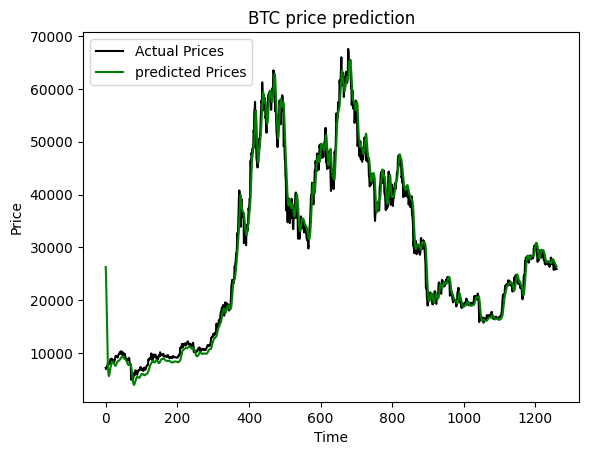

In [48]:

plt.plot(actual_prices, color='black', label= 'Actual Prices')
plt.plot(prediction_price, color='green', label= 'predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc= 'upper left')
plt.show()

In [53]:
#predict the next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days: len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))


prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 2s 2s/step
[[26294.412]]


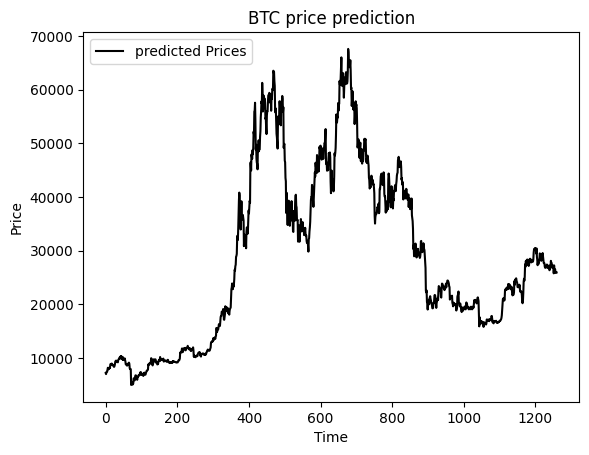

In [56]:
plt.plot(actual_prices, color='black', label= 'predicted Prices')
#plt.plot(prediction, color='green', label= 'predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc= 'upper left')
plt.show()